<H1>IMPORTING LIB</H1>

In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.optim.adamw import AdamW

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [2]:
df=pd.read_csv("../final_dataset2.csv")
df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
101470,Just realized that the Windows partition of my...,positive
101471,Just realized that my Mac window partition is ...,positive
101472,Just realized the windows partition of my Mac ...,positive
101473,Just realized between the windows partition of...,positive


In [3]:
df.shape

(101475, 2)

In [4]:
df=df[df.sentiment!='irrelevant']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88600 entries, 0 to 101474
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       88600 non-null  object
 1   sentiment  88600 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [6]:
conversion={
    'negative':0,
    'neutral':1,
    'positive':2
}

In [7]:
class_names = ['negative', 'neutral', 'positive']

In [8]:
df.sentiment=df.sentiment.apply(lambda x:conversion[x])

C:\Users\ganes\AppData\Local\Temp\ipykernel_22324\1649503820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sentiment=df.sentiment.apply(lambda x:conversion[x])


In [9]:
df

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
101470,Just realized that the Windows partition of my...,2
101471,Just realized that my Mac window partition is ...,2
101472,Just realized the windows partition of my Mac ...,2
101473,Just realized between the windows partition of...,2


<h1>PREPROCESSING</H1>

In [10]:
import preprocessor as pre

In [11]:
pr=pre.Preprocessor()

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

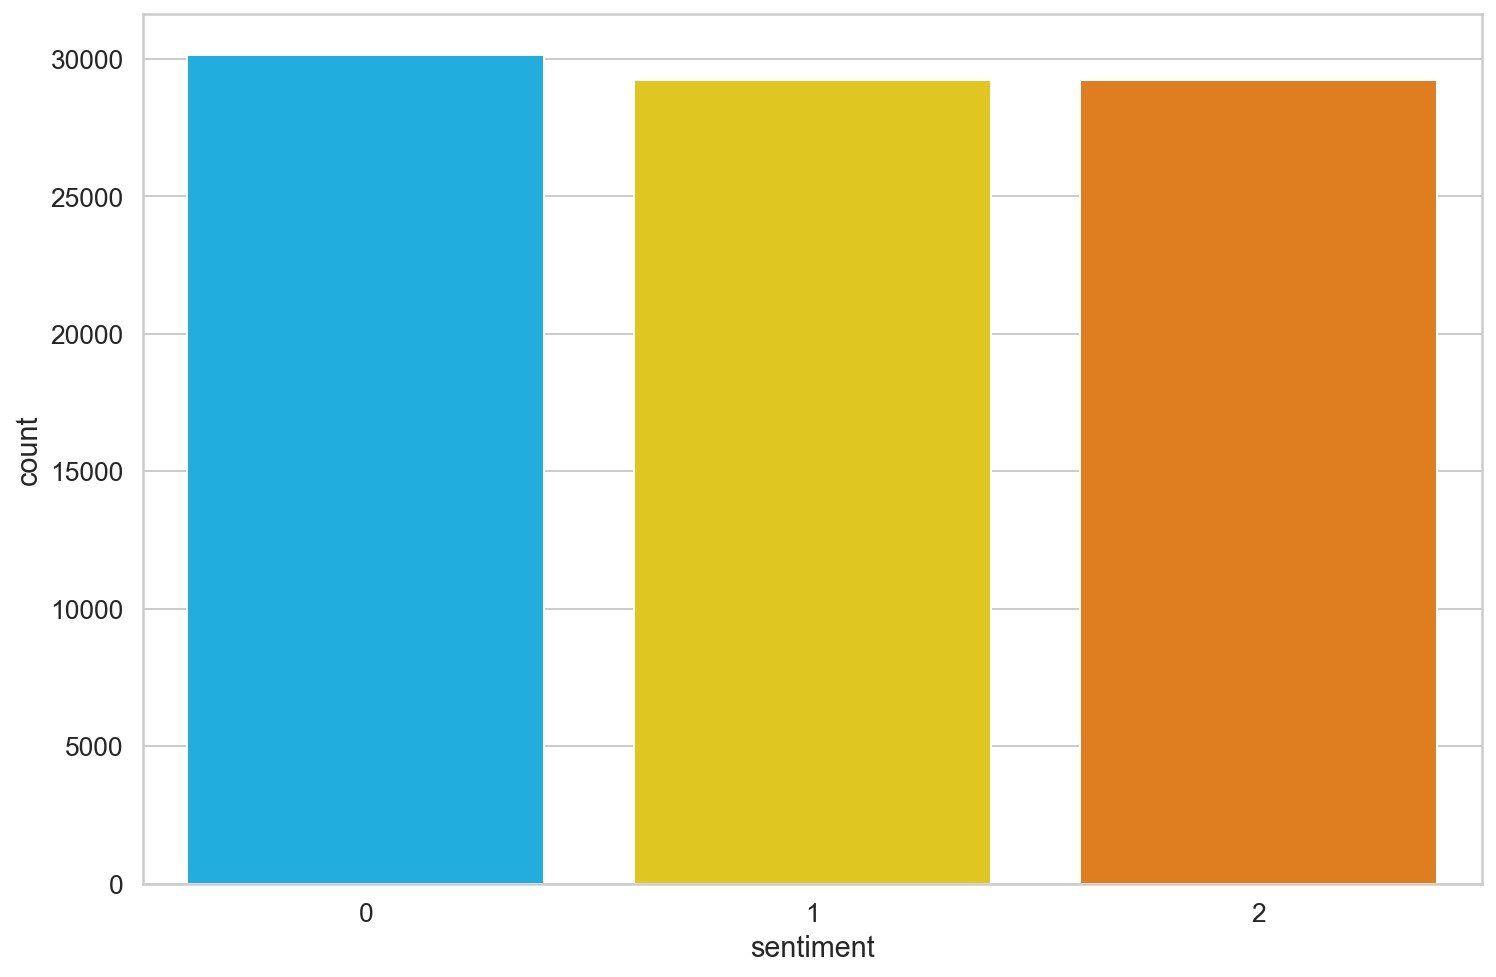

In [12]:
sns.countplot(df.sentiment)

In [13]:
df=df[df.sentiment!='irrelevant']

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

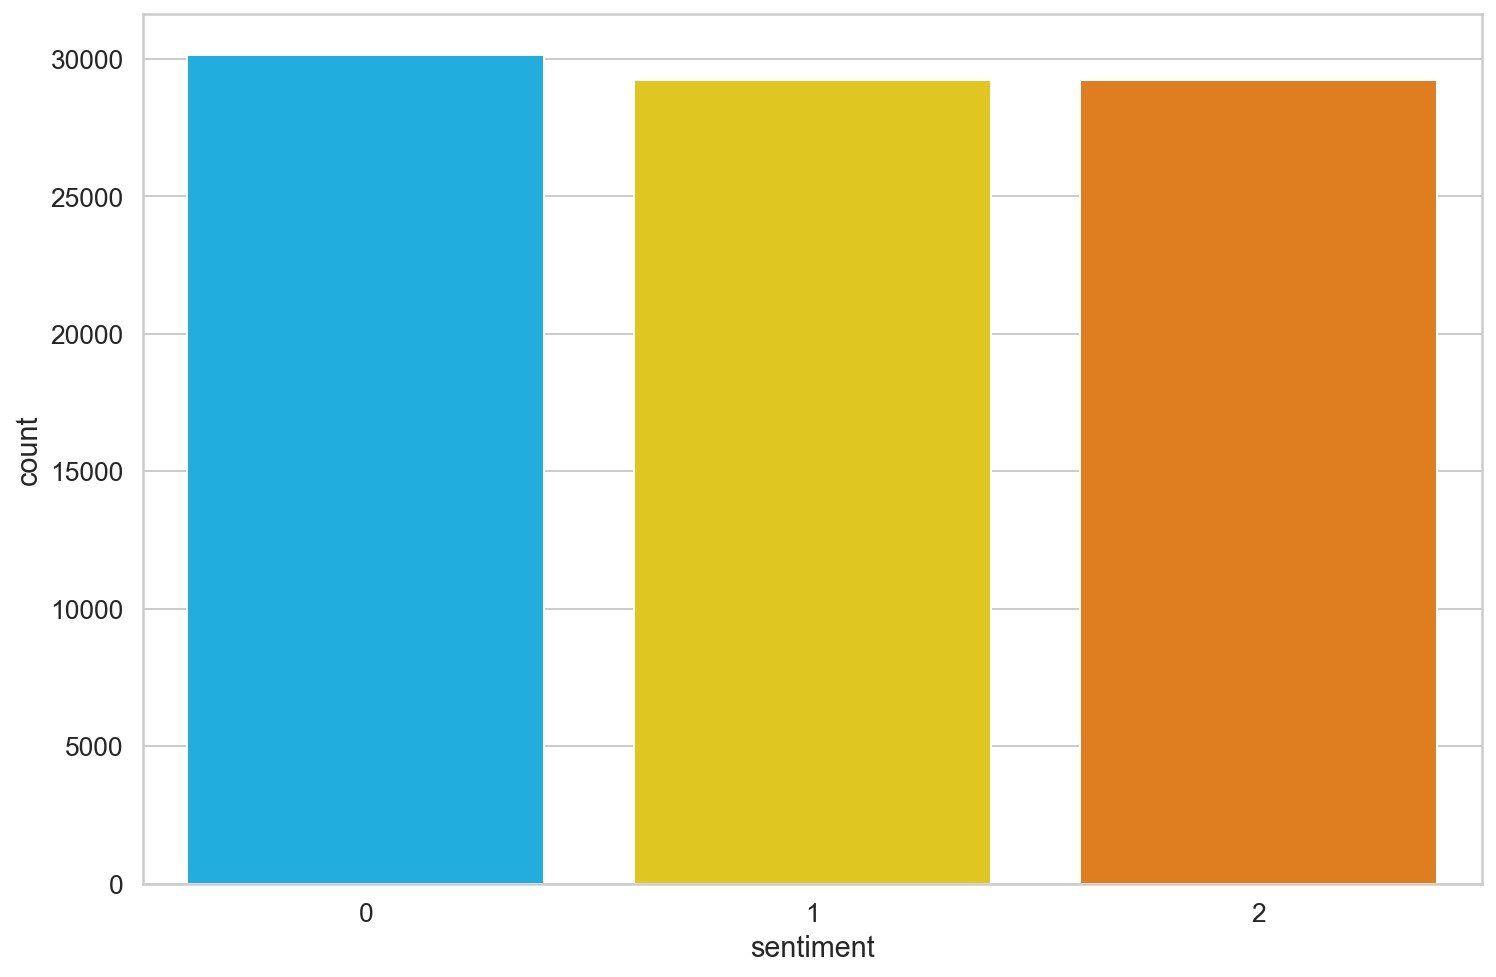

In [14]:
sns.countplot(df.sentiment)

In [15]:
df.text=df.text.apply(lambda x:pr.call_all_func(x))

In [16]:
df

,text,sentiment
0,Id have responded if I were going,1
1,Sooo SAD I will miss you here in San Diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,Sons of why couldnt they put them on the relea...,0
...,...,...
101470,Just realized that the Windows partition of my...,2
101471,Just realized that my Mac window partition is ...,2
101472,Just realized the windows partition of my Mac ...,2
101473,Just realized between the windows partition of...,2


In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
tokenizer.sep_token_id

102

In [20]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [25]:
token_len=[]

for txt in df.text:
    token=tokenizer.encode(txt,max_length=512)
    token_len.append(len(token))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'token count')

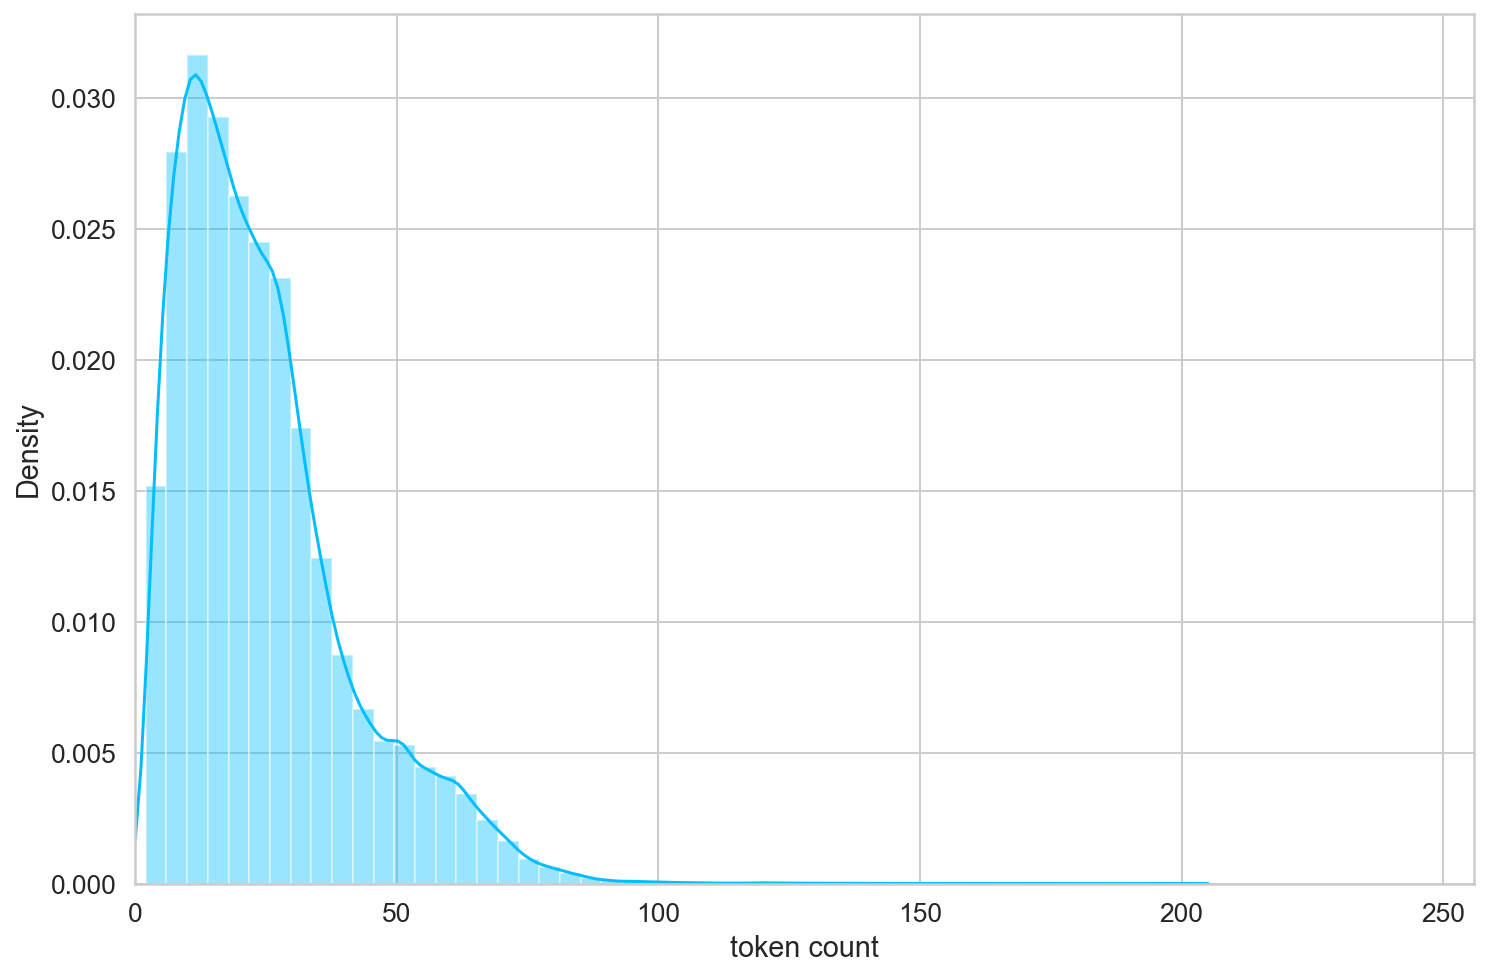

In [26]:
sns.distplot(token_len)
plt.xlim([0,256])
plt.xlabel('token count')

In [27]:
MAX_LEN=160

In [28]:
np_txt=df.text.to_numpy()[:100]

In [29]:
np_txt

array(['Id have responded if I were going',
       'Sooo SAD I will miss you here in San Diego',
       'my boss is bullying me', 'what interview leave me alone',
       'Sons of why couldnt they put them on the releases we already bought',
       'some shameless plugging for the best Rangers forum on earth',
       '2am feedings for the baby are fun when he is all smiles and coos',
       'Soooo high', 'Both of you',
       'Journey Wow u just became cooler hehe is that possible',
       'as much as i love to be hopeful i reckon the chances are minimal P im never gonna get my cake and stuff',
       'I really really like the song Love Story by Taylor Swift',
       'My Sharpie is running DANGERously low on ink',
       'i want to go to music tonight but i lost my voice',
       'test test from the LG enV2', 'Uh oh I am sunburned',
       'Sok trying to plot alternatives as we speak sigh',
       'ive been sick for the past few days and thus my hair looks wierd if i didnt have a hat on

In [30]:
class Tweetdataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88600 entries, 0 to 101474
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       88600 non-null  object
 1   sentiment  88600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


In [32]:
df_train,df_test=train_test_split(df,test_size=0.5,random_state=RANDOM_SEED)
df_val,df_test=train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44300 entries, 90038 to 15795
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       44300 non-null  object
 1   sentiment  44300 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [34]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22150 entries, 21358 to 31020
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22150 non-null  object
 1   sentiment  22150 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 519.1+ KB


In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22150 entries, 73403 to 1734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22150 non-null  object
 1   sentiment  22150 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 519.1+ KB


c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

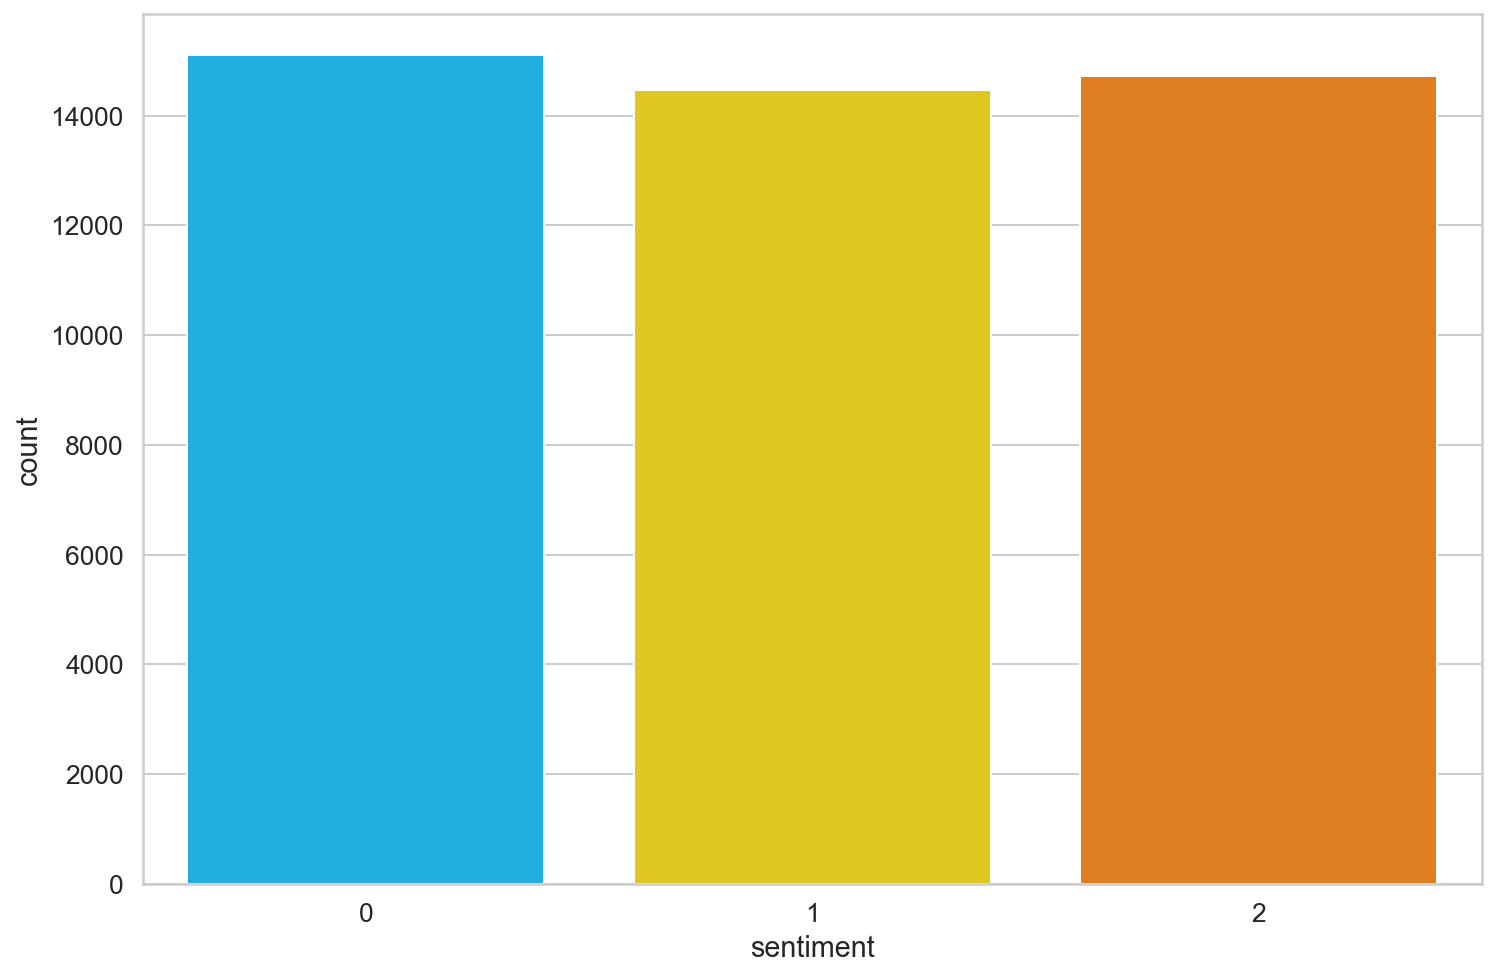

In [36]:
sns.countplot(df_train.sentiment)

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

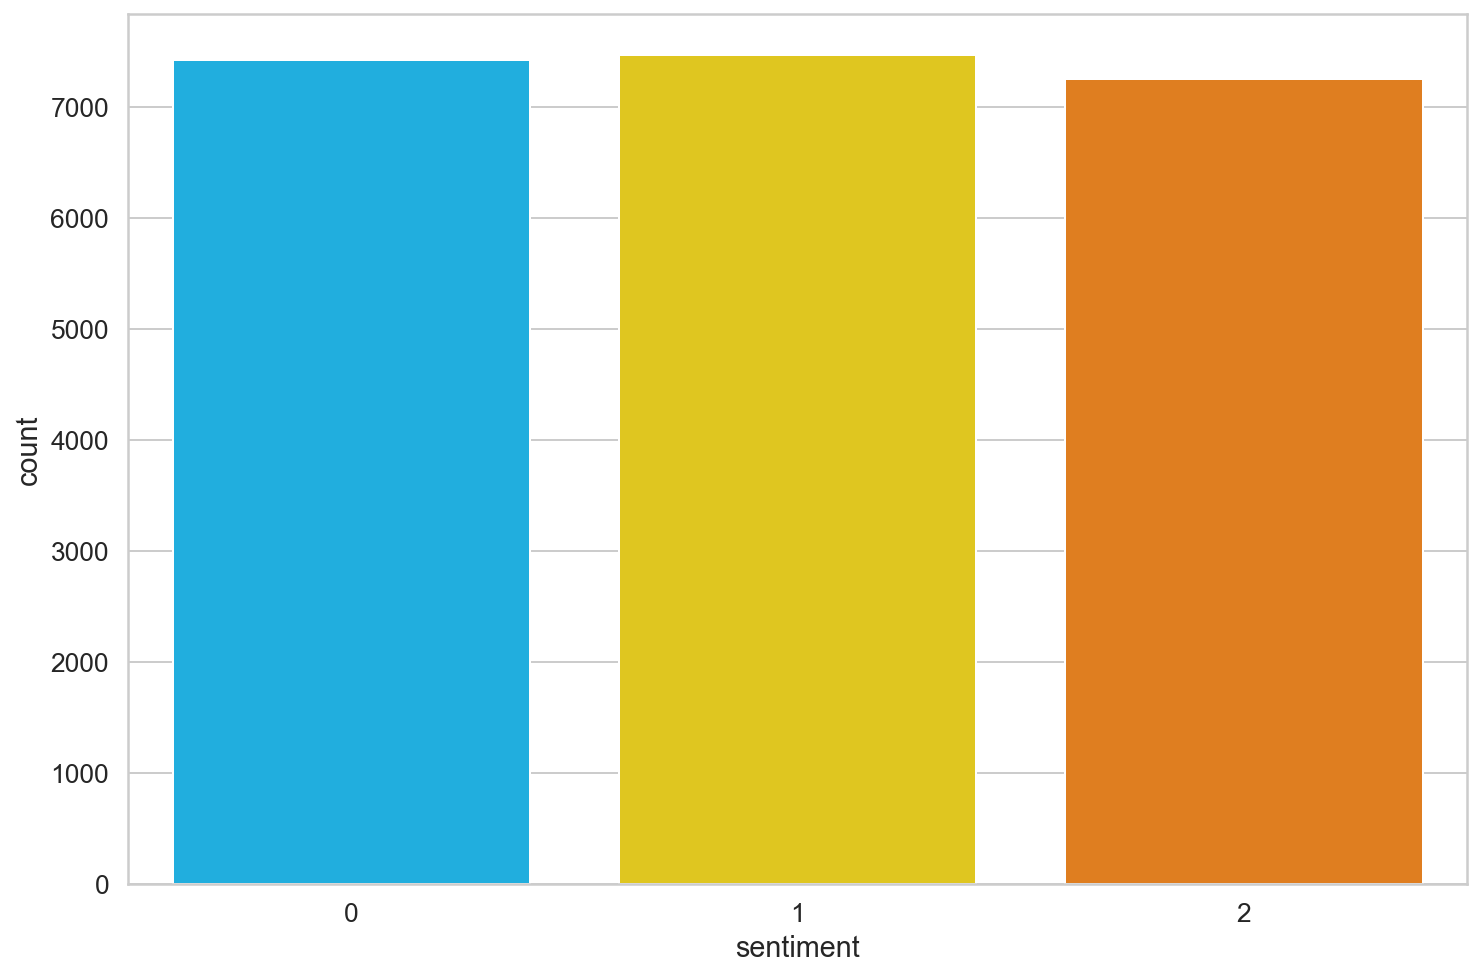

In [37]:
sns.countplot(df_test.sentiment)

In [38]:
df_train.shape,df_test.shape,df_val.shape

((44300, 2), (22150, 2), (22150, 2))

In [39]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweetdataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [40]:
BATCH_SIZE = 10

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [41]:
data = next(iter(train_data_loader))
data.keys()

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [42]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([10, 160])
torch.Size([10, 160])
torch.Size([10])


<h1>SENTIMENT CLASSIFICATION</H1>

In [43]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
a=bert_model(input_ids=encoding['input_ids'],attention_mask=encoding['attention_mask'])

In [45]:
a['last_hidden_state']

tensor([[[ 0.4070,  0.1858, -0.2489,  ..., -0.0298,  0.1574, -0.0787],
         [ 0.2521, -0.4902,  0.4746,  ..., -0.3883,  0.2401, -0.1347],
         [ 0.0866, -0.0274, -0.5215,  ...,  0.6011, -0.2430,  0.6801],
         ...,
         [ 0.0907,  0.1219, -0.3152,  ...,  0.0500,  0.0258,  0.2034],
         [ 0.0084,  0.2015,  0.0708,  ..., -0.0751,  0.2075, -0.0857],
         [ 0.0273,  0.2316,  0.1510,  ..., -0.1111,  0.0845, -0.1100]]],
       grad_fn=<NativeLayerNormBackward0>)

In [46]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    o= self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(o['pooler_output'])
    return self.out(output)

In [47]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([10, 160])
torch.Size([10, 160])


In [49]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2351, 0.4548, 0.3101],
        [0.2299, 0.3619, 0.4082],
        [0.3415, 0.2467, 0.4118],
        [0.1987, 0.4183, 0.3830],
        [0.5598, 0.2135, 0.2266],
        [0.2177, 0.4369, 0.3453],
        [0.2758, 0.3301, 0.3941],
        [0.3776, 0.2284, 0.3940],
        [0.3659, 0.2003, 0.4338],
        [0.3221, 0.2118, 0.4662]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

<h2>TRAINING</H2>

In [50]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [51]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


KeyboardInterrupt: 